# Live cu-inj-live-impact 

In [1]:
# Setup directories, and convert dashboard notebook to a script for importing
#!./setup.bash

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from impact import evaluate_impact_with_distgen, run_impact_with_distgen
from impact.tools import isotime
from impact.evaluate import  default_impact_merit
from impact import Impact

from make_dashboard import make_dashboard
from get_vcc_image import get_live_distgen_xy_dist, VCC_DEVICE_PV

from lcls_live.tools import NpEncoder

import matplotlib as mpl

from pmd_beamphysics.units import e_charge

CPU times: user 1e+03 ns, sys: 2 µs, total: 3 µs
Wall time: 3.81 µs


In [4]:
import pandas as pd
import numpy as np

import h5py
import json
import epics

import sys
import os
import toml
from time import sleep, time


import matplotlib.pyplot as plt

import matplotlib as mpl
#mpl.use('Agg')

# Nicer plotting
%config InlineBackend.figure_format = 'retina'

# Logging

In [5]:
#MODEL = 'f2e_inj'
#MODEL = 'cu_inj'


In [6]:
DEBUG=False
USE_VCC = False
LIVE = False
SNAPSHOT = 'examples/sc_inj-snapshot-2022-11-12T12:38:08-08:00.h5'
MIN_CHARGE_pC = 10

MODEL = 'sc_inj'
config = toml.load(f"configs/local_sc_inj.toml")


In [7]:
PREFIX = f'lume-impact-live-demo-{MODEL}'

In [8]:
import logging

# Gets or creates a logger
logger = logging.getLogger(PREFIX)  

# set log level
logger.setLevel(logging.INFO)

# define file handler and set formatter
file_handler = logging.FileHandler(f'{PREFIX}.log')
#formatter    = logging.Formatter('%(asctime)s : %(levelname)s : %(name)s : %(message)s')
formatter    = logging.Formatter(fmt="%(asctime)s :  %(name)s : %(message)s ", datefmt="%Y-%m-%dT%H:%M:%S%z")

# Add print to stdout
logger.addHandler(logging.StreamHandler(sys.stdout))

file_handler.setFormatter(formatter)

# add file handler to logger
logger.addHandler(file_handler)

## Utils

In [9]:
# Saving and loading
def save_pvdata(filename, pvdata, isotime):
    with h5py.File(filename, 'w') as h5:
        h5.attrs['isotime'] = np.string_(isotime)
        for k, v in pvdata.items():
            if isinstance(v, str):
                v =  np.string_(v)
            h5[k] = v 
def load_pvdata(filename):
    
    if not os.path.exists(filename):
        raise ValueError(f'H5 file does not exist: {filename} ')
    pvdata = {}
    with h5py.File(filename, 'r') as h5:
        isotime = h5.attrs['isotime']
        for k in h5:
            v = np.array(h5[k])        
            if v.dtype.char == 'S':
                v = str(v.astype(str))
            pvdata[k] = v
            
    return pvdata, isotime
# save_pvdata('test.h5', PVDATA, isotime()) 
# load_pvdata('test.h5')

# Configuration

Set up basic input sources and output path, loaded from toml environment file.

See README for required toml definition.

In [10]:
HOST = config.get('host') # mcc-simul or 'sdf'
if not HOST:
    raise ValueError("host not defined in toml.")
    
def get_path(key):
    val = config.get(key)
    if not val:
        raise ValueError(f"{key} not defined in toml.")
    val=os.path.expandvars(val)
    if not os.path.exists(val):
        raise ValueError(f"{val} does not exist")
    return os.path.abspath(val)


# Output dirs

SUMMARY_OUTPUT_DIR = get_path('summary_output_dir')



ARCHIVE_DIR = get_path('archive_dir')

SNAPSHOT_DIR = get_path('snapshot_dir')


# Dummy file for distgen
DISTGEN_LASER_FILE = config.get('distgen_laser_file')
if not DISTGEN_LASER_FILE:
    raise ValueError("distgen_laser_file not defined in toml.")

# Number of processors
NUM_PROCS = config.get('num_procs')
if not NUM_PROCS:
    raise ValueError("num_procs not defined in toml.")
else:
    NUM_PROCS = int(NUM_PROCS)


# if using sdf:
if HOST == 'sdf':    
    # check that environment variables are configured for execution
    IMPACT_COMMAND = config.get("impact_command")
    if not IMPACT_COMMAND:
        raise ValueError("impact_command not defined in toml.")


    IMPACT_COMMAND_MPI = config.get("impact_command_mpi")
    if not IMPACT_COMMAND_MPI:
        raise ValueError("impact_command_mpi not defined in toml.")



In [11]:
CONFIG0 = {}

# Base settings
SETTINGS0 = {
 'distgen:n_particle': 10_000,   
 'timeout': 10000,
 'header:Nx': 32,
 'header:Ny': 32,
 'header:Nz': 32,
 'numprocs': NUM_PROCS,
# 'mpi_run': MPI_RUN_CMD
   }

SETTINGS0['numprocs'] = NUM_PROCS
CONFIG0["workdir"] = get_path('workdir')

if DEBUG:
    logger.info('DEBUG MODE: Running without space charge for speed. ')
    SETTINGS0['distgen:n_particle'] = 1000
    SETTINGS0['total_charge'] = 0
    
    

    
# Host config    
if HOST in ('sdf', ):
    
     # SDF setup 
    SETTINGS0['command'] =  IMPACT_COMMAND
    SETTINGS0['command_mpi'] =  IMPACT_COMMAND_MPI
    SETTINGS0['mpi_run'] = config.get("mpi_run_cmd")
    
elif HOST == 'local':
    logger.info('Running locally')
    
else:
    raise ValueError(f'Unknown host: {HOST}')
    

Running locally


# Select: LCLS or FACET

In [12]:
# PV -> Sim conversion table
CSV =  f'pv_mapping/{MODEL}_impact.csv'  


CONFIG0['impact_config']      =  get_path('config_file')
CONFIG0['distgen_input_file'] =  get_path('distgen_input_file')

PLOT_OUTPUT_DIR = get_path('plot_output_dir')




if MODEL == 'cu_inj':
    VCC_DEVICE = 'CAMR:IN20:186' # LCLS   
    
    DASHBOARD_KWARGS = {'outpath':PLOT_OUTPUT_DIR,
                    'screen1': 'YAG02',
                    'screen2': 'YAG03',
                    'screen3': 'OTR2',
                    'ylim' : (0, None), # Emittance scale   
                    'ylim2': (0, None), # sigma_x scale
                    'name' : PREFIX
                   }    
    
    SETTINGS0['stop'] = 16.5
    SETTINGS0['distgen:t_dist:length:value'] =  4 * 1.65   #  Inferred pulse stacker FWHM: 4 ps, converted to tukey length
    
if MODEL == 'sc_inj':
    VCC_DEVICE = 'CAMR:LGUN:950' # LCLS-II 
    
    DASHBOARD_KWARGS = {'outpath':PLOT_OUTPUT_DIR,
                    'screen1': 'YAG01B',
                    'screen2': 'BEAM0',
                    'screen3': 'OTR0H04',
                    'ylim' : (0, 3e-6), # Emittance scale   
                    'ylim2': (0, None), # sigma_x scale                    
                    'name' : PREFIX
                   }    
    
    SETTINGS0['stop'] = 28
    SETTINGS0['distgen:t_dist:sigma_t:value'] =  16 / 2.355   # ps, equivalent to 16ps FWHM from Feng
    
elif MODEL == 'f2e_inj':
    VCC_DEVICE = 'CAMR:LT10:900' # FACET-II
    
    DASHBOARD_KWARGS = {'outpath':PLOT_OUTPUT_DIR,
                    'screen1': 'PR10241',
                    'screen2': 'PR10465',
                    'screen3': 'PR10571',
                    'ylim' : (0, 20e-6), # Emittance scale
                    'name' : PREFIX
                   }        
    
    SETTINGS0['distgen:t_dist:length:value'] =  3.65 * 1.65   #  Measured FWHM: 3.65 ps, converted to tukey length
     
else:
    raise

In [13]:
CONFIG0, SETTINGS0

({'workdir': '/Users/chrisonian/Code/GitHub/lume-impact-live-demo/output',
  'impact_config': '/Users/chrisonian/Code/GitHub/lcls-lattice/impact/models/sc_inj/v1/ImpactT.yaml',
  'distgen_input_file': '/Users/chrisonian/Code/GitHub/lcls-lattice/distgen/models/sc_inj/vcc_image/distgen.yaml'},
 {'distgen:n_particle': 10000,
  'timeout': 10000,
  'header:Nx': 32,
  'header:Ny': 32,
  'header:Nz': 32,
  'numprocs': 8,
  'stop': 28,
  'distgen:t_dist:sigma_t:value': 6.794055201698514})

# Set up monitors

In [14]:
# Gun: 700 kV
# Buncher: 200 keV energy gain
# Buncher: +60 deg relative to on-crest

In [15]:
DF = pd.read_csv(CSV)#.dropna()

PVLIST = list(DF['device_pv_name'].dropna()) 
if USE_VCC:
    PVLIST = PVLIST + list(VCC_DEVICE_PV[VCC_DEVICE].values())

#DF.set_index('device_pv_name', inplace=True)
DF

,Variable,bmad_name,device_pv_name,pv_unit,impact_name,impact_factor,impact_offset,impact_description,impact_unit
0,Gun Voltage,RFGUNB,SOLN:GUNB:212:BACT,xxx,RFGUNB:rf_field_scale,0.000000e+00,1.840000e+07,Value for 700 kV,V/m
1,Gun phase,RFGUNB,SOLN:GUNB:212:BACT,xxx,RFGUNB:autophase_deg,0.000000e+00,0.000000e+00,NaN,deg
2,Solenoid 1,SOL1B,SOLN:GUNB:212:BACT,kG*m,SOL1B:solenoid_field_scale,1.159555e+00,0.000000e+00,peak field,T
3,Solenoid 2,SOL2B,SOLN:GUNB:823:BACT,kG*m,SOL2B:solenoid_field_scale,1.159555e+00,0.000000e+00,peak field,T
4,charge,CATHODE,BPMS:GUNB:314:TMIT,n_electrons,distgen:total_charge:value,1.600000e-07,0.000000e+00,total charge on cathode,pC
5,Buncher Voltage,BUN1B,ACCL:GUNB:455:AACT_AVG,MV,BUN1B:rf_field_scale,0.000000e+00,1.786301e+06,values for 200 kV,V/m
6,Buncher Phase,BUN1B,ACCL:GUNB:455:PACT_AVG,deg,BUN1B:autophase_deg,0.000000e+00,-6.000000e+01,phase relative to on-crest,deg
7,Cavity 1 voltage,CAVL011,ACCL:L0B:0110:AACTMEAN,MV,CAVL011:rf_field_scale,1.861947e+06,0.000000e+00,peak on-axis electric field,V/m
8,Cavity 2 voltage,CAVL012,ACCL:L0B:0120:AACTMEAN,MV,CAVL012:rf_field_scale,1.861947e+06,0.000000e+00,peak on-axis electric field,V/m
9,Cavity 3 voltage,CAVL013,ACCL:L0B:0130:AACTMEAN,MV,CAVL013:rf_field_scale,1.861947e+06,0.000000e+00,peak on-axis electric field,V/m


In [16]:
if LIVE:
    MONITOR = {pvname:epics.PV(pvname) for pvname in PVLIST}
    SNAPSHOT = None
    sleep(5)

In [17]:
def get_snapshot(snapshot_file=None):
        
    if LIVE:
        itime = isotime()
        pvdata =  {k:MONITOR[k].get() for k in MONITOR}
    else:
        print(snapshot_file)
        pvdata, itime = load_pvdata(snapshot_file)
        itime = itime.decode('utf-8')
    
    logger.info(f'Acquired settings from EPICS at: {itime}')
    
    for k, v in pvdata.items():
        
        if v is None:
            raise ValueError(f'EPICS get for {k} returned None')
        
        if ':IMAGE:ARRAYDATA' in k.upper():
            found = False
            while not found:
                if v is None:
                    continue
                if v.std() > 10:
                    found = True
                else:
                    v = MONITOR[k].get()
            if v.ptp() < 128:
                v = v.astype(np.int8) # Downcast preeptively 
                                
            pvdata[k] = v
    return pvdata, itime
PVDATA, ITIME = get_snapshot(SNAPSHOT)
PVDATA, ITIME

examples/sc_inj-snapshot-2022-11-12T12:38:08-08:00.h5
Acquired settings from EPICS at: 2022-11-12T12:38:08-08:00


({'ACCL:GUNB:455:AACT_AVG': array(0.13420882),
  'ACCL:GUNB:455:PACT_AVG': array(24.99961809),
  'ACCL:L0B:0110:AACTMEAN': array(7.5103974),
  'ACCL:L0B:0110:PACTMEAN': array(-0.00051576),
  'ACCL:L0B:0120:AACTMEAN': array(0.00180498),
  'ACCL:L0B:0120:PACTMEAN': array(51.95295584),
  'ACCL:L0B:0130:AACTMEAN': array(7.00978007),
  'ACCL:L0B:0130:PACTMEAN': array(-0.00017127),
  'ACCL:L0B:0140:AACTMEAN': array(14.02005174),
  'ACCL:L0B:0140:PACTMEAN': array(-3.38856809e-05),
  'ACCL:L0B:0150:AACTMEAN': array(12.51761206),
  'ACCL:L0B:0150:PACTMEAN': array(-0.00047081),
  'ACCL:L0B:0160:AACTMEAN': array(12.01685661),
  'ACCL:L0B:0160:PACTMEAN': array(-7.17889108e-05),
  'ACCL:L0B:0170:AACTMEAN': array(13.01834673),
  'ACCL:L0B:0170:PACTMEAN': array(-0.00033593),
  'ACCL:L0B:0180:AACTMEAN': array(13.21857734),
  'ACCL:L0B:0180:PACTMEAN': array(0.00043308),
  'BPMS:GUNB:314:TMIT': array(3.12953984e+08),
  'QUAD:HTR:120:BACT': array(-2.02875644),
  'QUAD:HTR:140:BACT': array(1.9938339),
  '

In [18]:
#while True:
#    get_pvdata()

# EPICS -> Simulation settings

In [19]:
def get_settings(csv, base_settings={}, snapshot_dir=None, snapshot_file=None):
    """
    Fetches live settings for all devices in the CSV table, and translates them to simulation inputs
     
    """
    df = DF[DF['device_pv_name'].notna()]
    assert len(df) > 0, 'Empty dataframe!'
    
    pv_names = list(df['device_pv_name'])

    pvdata, itime = get_snapshot(snapshot_file)
    
    if snapshot_dir and not snapshot_file:
        filename = os.path.abspath(os.path.join(snapshot_dir, f'{MODEL}-snapshot-{itime}.h5'))
        logger.info(f'EPICS shapshot written: {filename}')
        save_pvdata(filename, pvdata, itime)
        # DEBUG: check readback
        #pvdata, itime = load_pvdata(filename)

    df['pv_value'] = [pvdata[k] for k in pv_names]
    
    # Assign impact
    df['impact_value'] = df['impact_factor']*df['pv_value'] 
    if 'impact_offset' in df:
        df['impact_value'] = df['impact_value']  + df['impact_offset']

    # Collect settings
    settings = base_settings.copy()
    settings.update(dict(zip(df['impact_name'], df['impact_value'])))
    
    if DEBUG:
        settings['total_charge'] = 0
    else:
        settings['total_charge'] = 1 # Will be updated with particles

    # VCC image
    if USE_VCC:
        dfile, img, cutimg = get_live_distgen_xy_dist(filename=DISTGEN_LASER_FILE, vcc_device=VCC_DEVICE, pvdata=pvdata)        
    else:
        img, cutimg = None, None
        #settings['distgen:r_dist:max_r:value'] = 0.35 # TEMP        
    
    return settings, df, img, cutimg, itime

#res = get_settings(CSV, SETTINGS0, snapshot_dir='.')
#DF[['Variable', 'bmad_name', 'pv_value','pv_unit',  'device_min', 'device_max',  'impact_name', 'impact_factor', 'impact_unit',
#        'impact_description',  'impact_value']]
#res[1]

In [20]:
#get_settings(CSV, SETTINGS0, snapshot_dir='.', snapshot_file=SNAPSHOT)

In [21]:
# gfile = CONFIG0['distgen_input_file']
# from distgen import Generator
# #fout = res[0]
# G = Generator(gfile)
# #G['xy_dist:file'] =  DISTGEN_LASER_FILE #'distgen_laser.txt'
# if USE_VCC:
#     G['xy_dist:file'] = res[0]['distgen:xy_dist:file'] 
# G['n_particle'] = 100000
# G.run()
# G.particles.plot('x', 'y', figsize=(5,5))

In [22]:
DO_TIMING = False

if DO_TIMING:
    import numpy as np
    import time
    results = []
    tlist = []
    nlist = 2**np.arange(1,8, 1)[::-1]
    for n in nlist:
        t1 = time.time()
        LIVE_SETTINGS['numprocs'] = n
        print(f'running wit {n}')
        result = run_impact_with_distgen(LIVE_SETTINGS, **CONFIG0, verbose=False )
        results.append(result)
        dt = time.time() - t1
        tlist.append(dt)
        print(n, dt)     
        
    tlist, nlist        

# Get live values, run Impact-T, make dashboard

In [23]:
# Patch this into the function below for the dashboard creation
def my_merit(impact_object, itime):
    # Collect standard output statistics
    merit0 = default_impact_merit(impact_object)
    # Make the dashboard from the evaluated object
    plot_file = make_dashboard(impact_object, itime=itime, **DASHBOARD_KWARGS)
    #print('Dashboard written:', plot_file)
    logger.info(f'Dashboard written: {plot_file}')
    
    # Assign extra info
    merit0['plot_file'] = plot_file    
    merit0['isotime'] = itime
    
    # Clear any buffers
    plt.close('all')

    return merit0

In [24]:
MIN_CHARGE = 10

def run1():
    dat = {}
    
    # Acquire settings
    mysettings, df, img, cutimg, itime = get_settings(CSV,
                                                           SETTINGS0,
                                                           snapshot_dir=SNAPSHOT_DIR,
                                                          snapshot_file=SNAPSHOT)        
    dat['isotime'] = itime
    
    # Record inputs
    dat['inputs'] = mysettings
    dat['config'] = CONFIG0
    dat['pv_mapping_dataframe'] = df.to_dict()
    
    logger.info(f'Running evaluate_impact_with_distgen...')

    t0 = time()
    
    total_charge_pC = mysettings['distgen:total_charge:value']
    if total_charge_pC < MIN_CHARGE_pC:
        logger.info(f'total charge is too low: {total_charge_pC:.2f} pC, skipping')
        return dat
    
    outputs = evaluate_impact_with_distgen(mysettings,
                                       merit_f=lambda x: my_merit(x, itime),
                                       archive_path=ARCHIVE_DIR,
                                       **CONFIG0, verbose=True )
    
    dat['outputs'] =  outputs   
    logger.info(f'...finished in {(time()-t0)/60:.1f} min')
    fname = fname=f'{SUMMARY_OUTPUT_DIR}/{PREFIX}-{itime}.json'

    #json.dump(dat, open(fname, 'w'), cls=NpEncoder)
    #print('Written:', fname)
    logger.info(f'Output written: {fname}')
    return dat
    

In [25]:
CONFIG0

{'workdir': '/Users/chrisonian/Code/GitHub/lume-impact-live-demo/output',
 'impact_config': '/Users/chrisonian/Code/GitHub/lcls-lattice/impact/models/sc_inj/v1/ImpactT.yaml',
 'distgen_input_file': '/Users/chrisonian/Code/GitHub/lcls-lattice/distgen/models/sc_inj/vcc_image/distgen.yaml'}

In [26]:
%%time
result = run1()

examples/sc_inj-snapshot-2022-11-12T12:38:08-08:00.h5
Acquired settings from EPICS at: 2022-11-12T12:38:08-08:00
Running evaluate_impact_with_distgen...
Setting distgen n_particle = 10000
Setting impact timeout = 10000
Setting impact header:Nx = 32
Setting impact header:Ny = 32
Setting impact header:Nz = 32
Setting impact numprocs = 8
Setting Npcol, Nprow = 4, 2
Enabling MPI
Setting impact stop = 28
Removed element: stop_1
Set stop to s = 28
Setting distgen t_dist:sigma_t:value = 6.794055201698514
Setting impact RFGUNB:rf_field_scale = 18400000.0
Setting impact RFGUNB:autophase_deg = 0.0
Setting impact SOL1B:solenoid_field_scale = 0.05449666295586827
Setting impact SOL2B:solenoid_field_scale = 0.028757730622052658
Setting distgen total_charge:value = 50.07263744
Setting impact BUN1B:rf_field_scale = 1786301.125
Setting impact BUN1B:autophase_deg = -60.0
Setting impact CAVL011:rf_field_scale = 13983964.516374521
Setting impact CAVL012:rf_field_scale = 3360.773170767213
Setting impact CA

In [30]:
#result.keys()

In [31]:
# Basic config
#result['config']

In [32]:
# Simulation inputs
#result['inputs']

In [33]:
# Simulation outputs
# result['outputs']

# Show the plot 

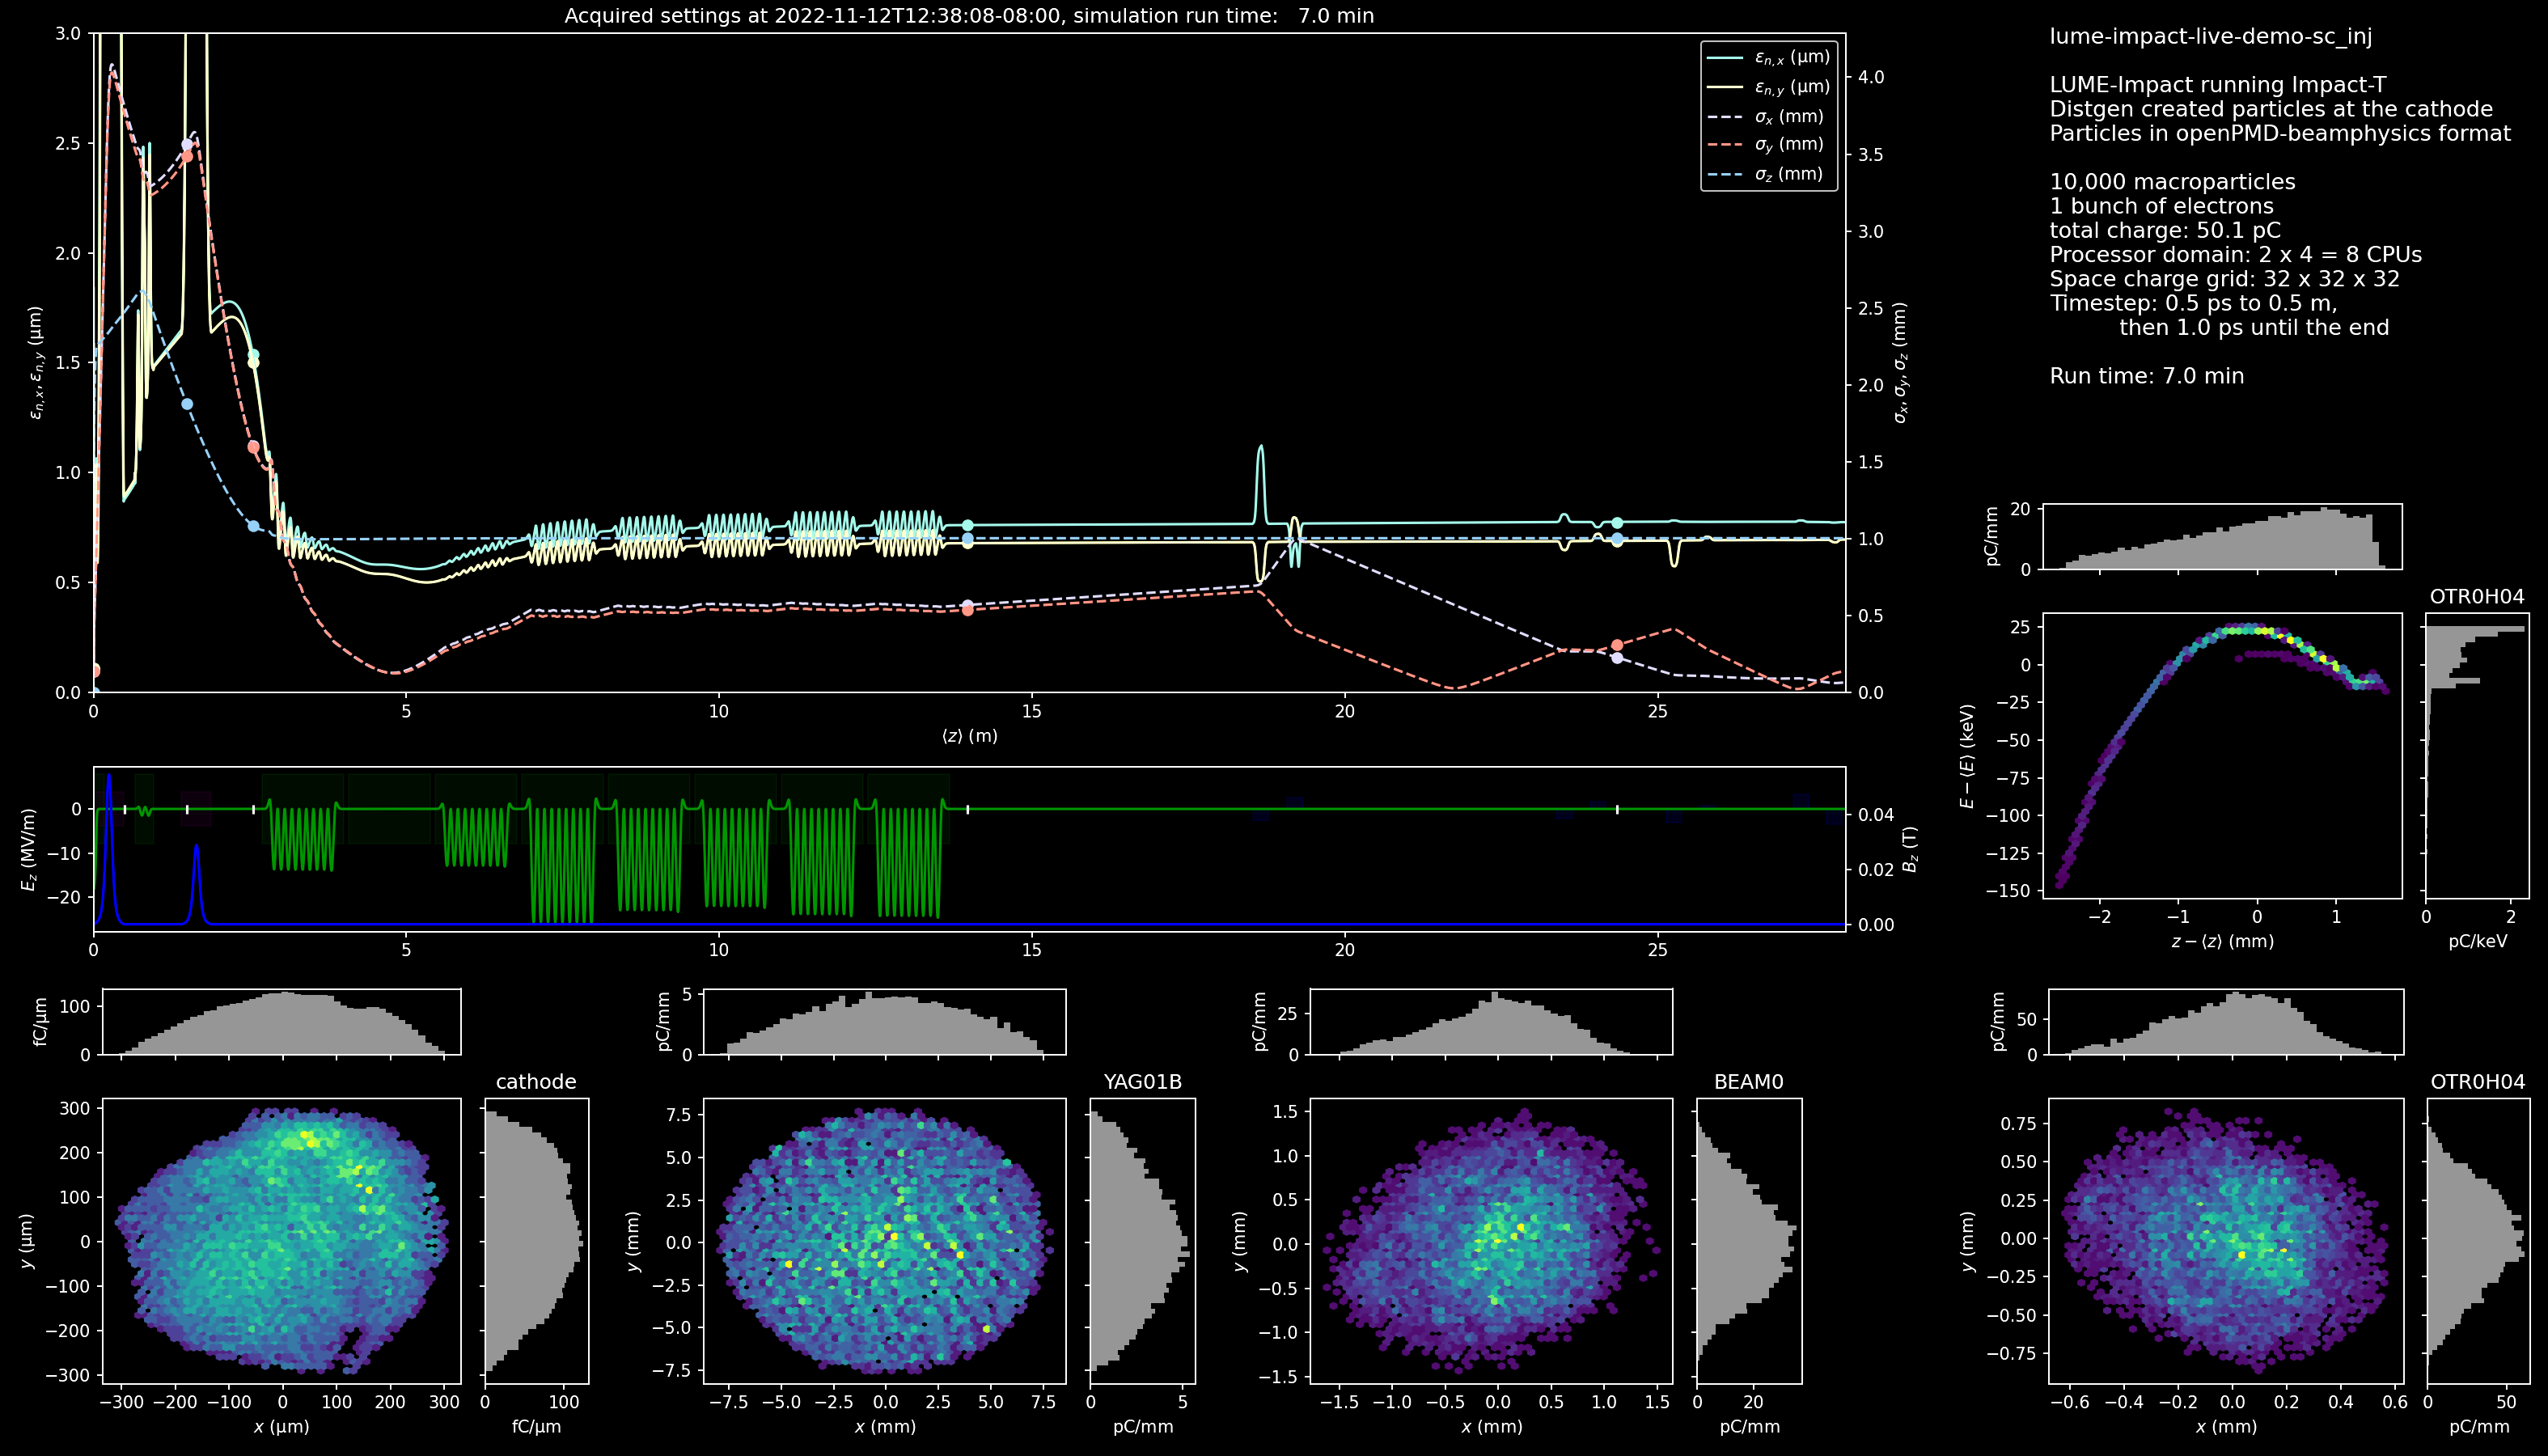

In [34]:
from IPython.display import Image
Image(filename=result['outputs']['plot_file'])

# loop it


In [ ]:
if __name__ == '__main__':
    while True:
        try:
            run1()
        except:
            sleep(10)
            logger.info('Something BAD happened. Sleeping for 10 s ...')